In notebook **3_build_model**, we let all the weights of the resnet model be updated when fine tuning on the EuroSAT dataset. One other way to finetune would be to only modify the weights of the final fully connected layer and freeze the other weights. 

Steps: 
1. Load resnet50 model
2. Load train,val,test data
3. Freeze all except the final fully connected layer 
4. Train the model 
5. Get performance on test data

In [42]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tqdm
from torchvision import models
from torchvision import datasets

In [29]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

In [ ]:
# #If running from colab
# from google.colab import drive
# drive.mount('/content/drive')

# data_folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data'

In [12]:
#If running locally
data_folder = 'data/'

In [13]:
dataset = datasets.ImageFolder(os.path.join(data_folder, 'EuroSAT','2750'))

In [14]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

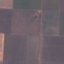

In [15]:
dataset[0][0]

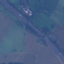

In [24]:
dataset[10000][0]

In [4]:
from torch.utils import data

In [6]:
class EuroSAT(data.Dataset):
    def __init__(self,dataset,transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x,y

    def __len__(self):
        return len(dataset)


In [10]:
train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
val_loader = torch.load(os.path.join(data_folder,'val_loader.pth'))
test_loader = torch.load(os.path.join(data_folder,'test_loader.pth'))

<ipython-input-10-0b32d987e57a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
<ipython-input-10-0b

In [25]:
model.fc = torch.nn.Linear(model.fc.in_features,len(dataset.classes))

In [30]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


In [31]:
model = model.to(device)

In [28]:
import torchsummary

In [32]:
torchsummary.summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
model.fc = torch.nn.Linear(model.fc.in_features,len(dataset.classes))

In [35]:
model = model.to(device)

In [44]:
lr = 0.001
epochs = 10

In [43]:
optimizer = torch.optim.SGD(model.parameters(),lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [38]:
def train(model,dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs,labels)

        loss.backward()

        optimizer.step()

        _,preds = torch.max(outputs,1)

        running_loss += loss.item() *inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct /  len(dataloader.dataset)) * 100
    print(f'Train loss : {epoch_loss:.2f};Accuracy : {epoch_accuracy:.2f}')

    return epoch_loss, epoch_accuracy

In [39]:
def evaluate(model,dataloader,criterion,phase='val'):
    model.eval()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1)

        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
    print(f'{phase.title()} Loss = {epoch_loss:.2f}; Accuracy = {epoch_accuracy:.2f}')

    return epoch_loss,epoch_accuracy

In [41]:
def fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer):
    best_loss = np.inf
    best_model = None

    for epoch in range(n_epochs):
        print(f'Epoch : {epoch+1}')
        train(model,train_loader,criterion,optimizer)
        val_loss,_ = evaluate(model,val_loader,criterion)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

    return best_model

In [ ]:
best_model = fit(model,train_loader,val_loader,n_epochs = epochs,criterion=criterion)